<a href="https://colab.research.google.com/github/LilInformat/UofT-3253-OzoneAnalysis/blob/master/OzoneNotebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Forecasting Ozone Days Pt.1

In [1]:
!pip install openml
!pip install tensorflow

In [0]:
import openml
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.svm import SVC, LinearSVC
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from pandas.plotting import scatter_matrix

pd.options.display.max_rows = 4000

openml.config.cache_directory = os.path.expanduser('/')
# openml.config.apikey = 'YOURKEY'

## Understand

Here we present the problem in which we wish to explore in this notebook, in that we wish to be able to forecast days in which Ozone levels are high. In this notebook, we will be looking at the 8hr peak dataset whose data was collected from 1998 to 2004 at the Houston, Galveston and Brazoria area.

A list of the features that are provided in this dataset can be found here:

https://archive.ics.uci.edu/ml/machine-learning-databases/ozone/

In total there are 72 Features and a single Target (DayClass). Using the features provided we will try to train a model that can forecast if it is an Ozone day or not.

## Load

In [3]:
# Iris dataset https://www.openml.org/d/1487
dataset = openml.datasets.get_dataset(1487)

# Print a summary
print(f"This is dataset '{dataset.name}', the target feature is "
      f"'{dataset.default_target_attribute}'")
print(f"URL: {dataset.url}")

This is dataset 'ozone-level-8hr', the target feature is 'Class'
URL: https://www.openml.org/data/v1/download/1592279/ozone-level-8hr.arff


In [0]:
raw_data = dataset.get_data(dataset_format='dataframe')

In [0]:
#Column Names can be found here: https://archive.ics.uci.edu/ml/machine-learning-databases/ozone/
df = raw_data[0]
df.columns= ['WSR0','WSR1','WSR2','WSR3','WSR4','WSR5','WSR6','WSR7','WSR8','WSR9','WSR10','WSR11','WSR12',
             'WSR13','WSR14','WSR15','WSR16','WSR17','WSR18','WSR19','WSR20','WSR21','WSR22','WSR23','WSR_PK',
             'WSR_AV','T0','T1','T2','T3','T4','T5','T6','T7','T8','T9','T10','T11','T12','T13','T14','T15',
             'T16','T17','T18','T19','T20','T21','T22','T23','T_PK','T_AV','T85','RH85','U85','V85','HT85','T70',
             'RH70','U70','V70','HT70','T50','RH50','U50','V50','HT50','KI','TT','SLP','SLP_','Precp','DayClass']

## Explore

In [6]:
print(df.shape)
df.head(10)

(2534, 73)


,WSR0,WSR1,WSR2,WSR3,WSR4,WSR5,WSR6,WSR7,WSR8,WSR9,WSR10,WSR11,WSR12,WSR13,WSR14,WSR15,WSR16,WSR17,WSR18,WSR19,WSR20,WSR21,WSR22,WSR23,WSR_PK,WSR_AV,T0,T1,T2,T3,T4,T5,T6,T7,T8,T9,T10,T11,T12,T13,T14,T15,T16,T17,T18,T19,T20,T21,T22,T23,T_PK,T_AV,T85,RH85,U85,V85,HT85,T70,RH70,U70,V70,HT70,T50,RH50,U50,V50,HT50,KI,TT,SLP,SLP_,Precp,DayClass
0,0.8,1.8,2.4,2.1,2.0,2.1,1.5,1.7,1.9,2.3,3.7,5.5,5.1,5.4,5.4,4.7,4.3,3.5,3.5,2.9,3.2,3.2,2.8,2.6,5.5,3.1,5.2,6.1,6.1,6.1,6.1,5.6,5.2,5.4,7.2,10.6,14.5,17.2,18.3,18.9,19.1,18.9,18.3,17.3,16.8,16.1,15.4,14.9,14.8,15.0,19.1,12.5,6.700000,0.11000,3.830000,0.140000,1612.00000,-2.300000,0.300000,7.180000,0.120000,3178.500000,-15.50000,0.150000,10.670000,-1.560000,5795.000000,-12.100000,17.900000,10330.000000,-55.000000,0.00,1
1,2.8,3.2,3.3,2.7,3.3,3.2,2.9,2.8,3.1,3.4,4.2,4.5,4.5,4.3,5.5,5.1,3.8,3.0,2.6,3.0,2.2,2.3,2.5,2.8,5.5,3.4,15.1,15.3,15.6,15.6,15.9,16.2,16.2,16.2,16.6,17.8,19.4,20.6,21.2,21.8,22.4,22.1,20.8,19.1,18.1,17.2,16.5,16.1,16.0,16.2,22.4,17.8,9.000000,0.25000,-0.410000,9.530000,1594.50000,-2.200000,0.960000,8.240000,7.300000,3172.000000,-14.50000,0.480000,8.390000,3.840000,5805.000000,14.050000,29.000000,10275.000000,-55.000000,0.00,1
2,2.9,2.8,2.6,2.1,2.2,2.5,2.5,2.7,2.2,2.5,3.1,4.0,4.4,4.6,5.6,5.4,5.2,4.4,3.5,2.7,2.9,3.9,4.1,4.6,5.6,3.5,16.6,16.7,16.7,16.8,16.8,16.8,16.9,16.9,17.1,17.6,19.1,21.3,21.8,22.0,22.1,22.2,21.3,19.8,18.6,18.0,18.0,18.2,18.3,18.4,22.2,18.7,9.000000,0.56000,0.890000,10.170000,1568.50000,0.900000,0.540000,3.800000,4.420000,3160.000000,-15.90000,0.600000,6.940000,9.800000,5790.000000,17.900000,41.300000,10235.000000,-40.000000,0.00,1
3,4.7,3.8,3.7,3.8,2.9,3.1,2.8,2.5,2.4,3.1,3.3,3.1,2.3,2.1,2.2,3.8,2.8,2.4,1.9,3.2,4.1,3.9,4.5,4.3,4.7,3.2,18.3,18.2,18.3,18.4,18.6,18.6,18.5,18.7,18.6,18.8,19.0,19.0,19.3,19.4,19.6,19.2,18.9,18.8,18.6,18.5,18.3,18.5,18.8,18.9,19.6,18.7,9.900000,0.89000,-0.340000,8.580000,1546.50000,3.000000,0.770000,4.170000,8.110000,3145.500000,-16.80000,0.490000,8.730000,10.540000,5775.000000,31.150000,51.700000,10195.000000,-40.000000,2.08,1
4,2.6,2.1,1.6,1.4,0.9,1.5,1.2,1.4,1.3,1.4,2.2,2.0,3.0,3.0,3.1,3.1,2.7,3.0,2.4,2.8,2.5,2.5,3.7,3.4,3.7,2.3,18.8,18.6,18.5,18.5,18.6,18.9,19.2,19.4,19.8,20.5,21.1,21.9,23.8,25.1,25.8,26.0,25.6,24.2,22.9,21.6,20.0,19.5,19.1,19.1,26.0,21.1,13.575298,0.57732,2.136487,1.662464,1531.49426,5.931129,0.406445,5.459634,0.994001,3145.420501,-10.51141,0.304716,9.872418,0.830116,5818.821222,10.511051,37.388335,10164.198442,-0.119949,0.58,1
5,3.1,3.5,3.3,2.5,1.6,1.7,1.6,1.6,2.3,1.8,2.5,3.9,3.4,2.7,3.4,2.5,2.2,4.4,4.3,3.2,6.2,6.8,5.1,4.0,6.8,3.2,18.9,19.5,19.6,19.5,19.5,19.5,19.4,19.2,19.1,19.5,19.6,18.6,18.6,18.9,19.2,19.3,19.2,18.8,17.6,16.9,15.6,15.4,15.9,15.8,19.6,18.5,14.400000,0.68000,1.520000,8.620000,1499.50000,4.300000,0.610000,9.040000,10.810000,3111.000000,-11.80000,0.090000,11.980000,11.280000,5770.000000,27.950000,46.250000,10120.000000,-0.119949,5.84,1
6,3.7,3.2,3.8,5.1,6.0,7.0,6.3,6.4,6.3,5.4,6.1,6.4,6.1,5.8,6.2,6.2,5.5,4.8,5.5,6.1,5.0,3.1,2.2,1.6,7.0,5.2,15.6,15.6,15.5,15.8,14.7,12.0,10.4,9.0,8.1,8.4,8.8,8.8,8.7,8.6,8.3,8.2,7.8,7.7,7.4,7.3,7.3,7.1,6.6,5.7,15.8,9.7,12.600000,0.98000,0.480000,7.460000,1413.00000,4.600000,0.530000,13.360000,15.340000,3027.500000,-11.80000,0.840000,6.860000,25.600000,5695.000000,26.750000,48.450000,10040.000000,-80.000000,0.18,1
7,2.2,2.9,3.4,4.2,4.7,4.7,5.3,4.9,5.2,6.0,5.9,6.1,6.8,6.3,6.3,6.4,5.7,3.6,1.5,0.7,0.0,0.0,0.8,0.5,6.8,3.9,5.5,5.8,6.0,6.0,5.9,6.1,6.3,6.6,6.9,7.8,9.1,10.5,11.6,12.8,13.9,14.7,14.9,14.2,12.2,10.1,8.8,7.1,5.9,6.1,14.9,9.0,3.350000,0.73000,16.140000,4.530000,1382.50000,-2.450000,0.080000,18.290000,8.030000,2933.000000,-20.10000,0.200000,19.220000,18.210000,5515.000000,-10.100000,42.000000,10065.000000,25.000000,0.00,1
8,1.0,1.5,1.2,1.2,0.7,0.5,1.2,1.4,1.5,2.1,2.6,3.2,3.1,3.9,4.1,3.6,3.4,3.0,2.9,2.5,1.9,2.0,1.3,1.2,4.1,2.1,5.1,5.1,4.7,4.3,3.8,3.3,3.6,3.7,4.7,7.1,10.8,13.7,15.5,16.2,16.7,17.0,16.4,14.8,13.2,12.8,12.2,11.9,11.8,11.7,17.0,10.0,3.900000,0.3800

In [7]:
df.describe()

,WSR0,WSR1,WSR2,WSR3,WSR4,WSR5,WSR6,WSR7,WSR8,WSR9,WSR10,WSR11,WSR12,WSR13,WSR14,WSR15,WSR16,WSR17,WSR18,WSR19,WSR20,WSR21,WSR22,WSR23,WSR_PK,WSR_AV,T0,T1,T2,T3,T4,T5,T6,T7,T8,T9,T10,T11,T12,T13,T14,T15,T16,T17,T18,T19,T20,T21,T22,T23,T_PK,T_AV,T85,RH85,U85,V85,HT85,T70,RH70,U70,V70,HT70,T50,RH50,U50,V50,HT50,KI,TT,SLP,SLP_,Precp
count,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000,2534.00000,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000,2534.00000,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000
mean,1.640179,1.586351,1.545580,1.526405,1.522624,1.542417,1.637896,2.047127,2.539037,2.847708,2.969768,3.016414,3.044148,3.106679,3.177738,3.231005,3.19280,2.934562,2.561343,2.285638,2.089554,1.938376,1.803805,1.708538,4.172092,2.314949,18.649275,18.34785,18.060886,17.821319,17.611319,17.475542,17.589366,18.417822,19.778799,21.216943,22.462532,23.393553,24.025245,24.433077,24.705081,24.720153,24.397532,23.632100,22.509702,21.425661,20.615352,20.031588,19.502647,19.062260,25.578338,20.840483,13.575298,0.577320,2.136487,1.662464,1531.494260,5.931129,0.406445,5.459634,0.994001,3145.420501,-10.511410,0.304716,9.872418,0.830116,5818.821222,10.511051,37.388335,10164.198442,-0.119949,0.372026
std,1.194568,1.191320,1.165651,1.133908,1.127523,1.102557,1.092811,1.092315,1.115448,1.150067,1.226213,1.304019,1.335290,1.355860,1.339908,1.292098,1.20807,1.163749,1.167420,1.141466,1.133256,1.136367,1.157232,1.186339,1.108616,0.871756,6.752344,6.82283,6.884705,6.938420,6.985407,7.043085,7.241698,7.582168,7.585859,7.469895,7.402258,7.333411,7.273891,7.178587,7.099197,7.028064,6.968902,6.916727,6.824704,6.661610,6.604597,6.608696,6.634095,6.696116,6.900412,6.766376,4.777721,0.252778,4.554302,5.911862,35.999852,3.784369,0.261882,6.465907,5.990767,48.194639,3.793266,0.242858,9.127381,7.043762,77.410110,20.154266,10.949074,51.428116,34.693349,1.317438
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.100000,0.000000,0.100000,0.000000,0.000000,0.100000,0.000000,0.20000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.800000,0.400000,-1.800000,-2.10000,-2.600000,-2.800000,-3.200000,-3.600000,-3.200000,-2.800000,-1.900000,-1.200000,-1.200000,-0.300000,0.300000,0.900000,1.500000,1.700000,0.600000,-0.600000,-0.200000,0.100000,0.200000,-0.300000,-1.400000,-1.200000,1.700000,0.300000,-7.100000,0.010000,-15.770000,-18.100000,1351.000000,-9.900000,0.010000,-14.370000,-23.680000,2919.000000,-24.800000,0.010000,-14.920000,-25.990000,5480.000000,-56.700000,-10.100000,9975.000000,-135.000000,0.000000
25%,0.800000,0.700000,0.700000,0.700000,0.700000,0.700000,0.800000,1.300000,1.800000,2.100000,2.100000,2.100000,2.100000,2.100000,2.200000,2.400000,2.40000,2.100000,1.800000,1.500000,1.300000,1.200000,1.000000,0.800000,3.400000,1.700000,14.025000,13.72500,13.300000,13.200000,12.900000,12.600000,12.525000,13.300000,14.800000,16.500000,17.900000,19.000000,19.900000,20.300000,20.725000,20.900000,20.400000,19.700000,18.400000,17.400000,16.500000,15.700000,15.025000,14.600000,21.700000,16.500000,10.700000,0.400000,-0.757500,-2.080000,1512.000000,3.625000,0.172500,0.932500,-2.470000,3118.125000,-13.200000,0.100000,3.130000,-3.340000,5771.250000,-2.437500,33.200000,10130.000000,-20.000000,0.000000
50%,1.600000,1.500000,1.400000,1.400000,1.400

We only have 2534 rows of data. Additionally, the values of these features are decimal and can be negative as well as be very large. This implies that we may want to use a MinMaxScaler depending on which model we train the data on. 

Notice that the describe did not show the DayClass column in the data.

In [8]:
print(df['DayClass'].values.unique())
print(df['DayClass'].dtype)

[1, 2]
Categories (2, object): [1 < 2]
category


We may need to convert this output to a numerical value as some classifiers may expect this value to be numerical. Since there are only two values, we can set 1's to 0 and 2's to 1.

In [9]:
print(df.isna().sum())

WSR0        0
WSR1        0
WSR2        0
WSR3        0
WSR4        0
WSR5        0
WSR6        0
WSR7        0
WSR8        0
WSR9        0
WSR10       0
WSR11       0
WSR12       0
WSR13       0
WSR14       0
WSR15       0
WSR16       0
WSR17       0
WSR18       0
WSR19       0
WSR20       0
WSR21       0
WSR22       0
WSR23       0
WSR_PK      0
WSR_AV      0
T0          0
T1          0
T2          0
T3          0
T4          0
T5          0
T6          0
T7          0
T8          0
T9          0
T10         0
T11         0
T12         0
T13         0
T14         0
T15         0
T16         0
T17         0
T18         0
T19         0
T20         0
T21         0
T22         0
T23         0
T_PK        0
T_AV        0
T85         0
RH85        0
U85         0
V85         0
HT85        0
T70         0
RH70        0
U70         0
V70         0
HT70        0
T50         0
RH50        0
U50         0
V50         0
HT50        0
KI          0
TT          0
SLP         0
SLP_        0
Precp 

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2534 entries, 0 to 2533
Data columns (total 73 columns):
WSR0        2534 non-null float64
WSR1        2534 non-null float64
WSR2        2534 non-null float64
WSR3        2534 non-null float64
WSR4        2534 non-null float64
WSR5        2534 non-null float64
WSR6        2534 non-null float64
WSR7        2534 non-null float64
WSR8        2534 non-null float64
WSR9        2534 non-null float64
WSR10       2534 non-null float64
WSR11       2534 non-null float64
WSR12       2534 non-null float64
WSR13       2534 non-null float64
WSR14       2534 non-null float64
WSR15       2534 non-null float64
WSR16       2534 non-null float64
WSR17       2534 non-null float64
WSR18       2534 non-null float64
WSR19       2534 non-null float64
WSR20       2534 non-null float64
WSR21       2534 non-null float64
WSR22       2534 non-null float64
WSR23       2534 non-null float64
WSR_PK      2534 non-null float64
WSR_AV      2534 non-null float64
T0       

In [11]:
df_converted = df.copy()
df_converted['DayClass'] = df_converted['DayClass'].astype('int32') - 1
df_converted.head(10)

,WSR0,WSR1,WSR2,WSR3,WSR4,WSR5,WSR6,WSR7,WSR8,WSR9,WSR10,WSR11,WSR12,WSR13,WSR14,WSR15,WSR16,WSR17,WSR18,WSR19,WSR20,WSR21,WSR22,WSR23,WSR_PK,WSR_AV,T0,T1,T2,T3,T4,T5,T6,T7,T8,T9,T10,T11,T12,T13,T14,T15,T16,T17,T18,T19,T20,T21,T22,T23,T_PK,T_AV,T85,RH85,U85,V85,HT85,T70,RH70,U70,V70,HT70,T50,RH50,U50,V50,HT50,KI,TT,SLP,SLP_,Precp,DayClass
0,0.8,1.8,2.4,2.1,2.0,2.1,1.5,1.7,1.9,2.3,3.7,5.5,5.1,5.4,5.4,4.7,4.3,3.5,3.5,2.9,3.2,3.2,2.8,2.6,5.5,3.1,5.2,6.1,6.1,6.1,6.1,5.6,5.2,5.4,7.2,10.6,14.5,17.2,18.3,18.9,19.1,18.9,18.3,17.3,16.8,16.1,15.4,14.9,14.8,15.0,19.1,12.5,6.700000,0.11000,3.830000,0.140000,1612.00000,-2.300000,0.300000,7.180000,0.120000,3178.500000,-15.50000,0.150000,10.670000,-1.560000,5795.000000,-12.100000,17.900000,10330.000000,-55.000000,0.00,0
1,2.8,3.2,3.3,2.7,3.3,3.2,2.9,2.8,3.1,3.4,4.2,4.5,4.5,4.3,5.5,5.1,3.8,3.0,2.6,3.0,2.2,2.3,2.5,2.8,5.5,3.4,15.1,15.3,15.6,15.6,15.9,16.2,16.2,16.2,16.6,17.8,19.4,20.6,21.2,21.8,22.4,22.1,20.8,19.1,18.1,17.2,16.5,16.1,16.0,16.2,22.4,17.8,9.000000,0.25000,-0.410000,9.530000,1594.50000,-2.200000,0.960000,8.240000,7.300000,3172.000000,-14.50000,0.480000,8.390000,3.840000,5805.000000,14.050000,29.000000,10275.000000,-55.000000,0.00,0
2,2.9,2.8,2.6,2.1,2.2,2.5,2.5,2.7,2.2,2.5,3.1,4.0,4.4,4.6,5.6,5.4,5.2,4.4,3.5,2.7,2.9,3.9,4.1,4.6,5.6,3.5,16.6,16.7,16.7,16.8,16.8,16.8,16.9,16.9,17.1,17.6,19.1,21.3,21.8,22.0,22.1,22.2,21.3,19.8,18.6,18.0,18.0,18.2,18.3,18.4,22.2,18.7,9.000000,0.56000,0.890000,10.170000,1568.50000,0.900000,0.540000,3.800000,4.420000,3160.000000,-15.90000,0.600000,6.940000,9.800000,5790.000000,17.900000,41.300000,10235.000000,-40.000000,0.00,0
3,4.7,3.8,3.7,3.8,2.9,3.1,2.8,2.5,2.4,3.1,3.3,3.1,2.3,2.1,2.2,3.8,2.8,2.4,1.9,3.2,4.1,3.9,4.5,4.3,4.7,3.2,18.3,18.2,18.3,18.4,18.6,18.6,18.5,18.7,18.6,18.8,19.0,19.0,19.3,19.4,19.6,19.2,18.9,18.8,18.6,18.5,18.3,18.5,18.8,18.9,19.6,18.7,9.900000,0.89000,-0.340000,8.580000,1546.50000,3.000000,0.770000,4.170000,8.110000,3145.500000,-16.80000,0.490000,8.730000,10.540000,5775.000000,31.150000,51.700000,10195.000000,-40.000000,2.08,0
4,2.6,2.1,1.6,1.4,0.9,1.5,1.2,1.4,1.3,1.4,2.2,2.0,3.0,3.0,3.1,3.1,2.7,3.0,2.4,2.8,2.5,2.5,3.7,3.4,3.7,2.3,18.8,18.6,18.5,18.5,18.6,18.9,19.2,19.4,19.8,20.5,21.1,21.9,23.8,25.1,25.8,26.0,25.6,24.2,22.9,21.6,20.0,19.5,19.1,19.1,26.0,21.1,13.575298,0.57732,2.136487,1.662464,1531.49426,5.931129,0.406445,5.459634,0.994001,3145.420501,-10.51141,0.304716,9.872418,0.830116,5818.821222,10.511051,37.388335,10164.198442,-0.119949,0.58,0
5,3.1,3.5,3.3,2.5,1.6,1.7,1.6,1.6,2.3,1.8,2.5,3.9,3.4,2.7,3.4,2.5,2.2,4.4,4.3,3.2,6.2,6.8,5.1,4.0,6.8,3.2,18.9,19.5,19.6,19.5,19.5,19.5,19.4,19.2,19.1,19.5,19.6,18.6,18.6,18.9,19.2,19.3,19.2,18.8,17.6,16.9,15.6,15.4,15.9,15.8,19.6,18.5,14.400000,0.68000,1.520000,8.620000,1499.50000,4.300000,0.610000,9.040000,10.810000,3111.000000,-11.80000,0.090000,11.980000,11.280000,5770.000000,27.950000,46.250000,10120.000000,-0.119949,5.84,0
6,3.7,3.2,3.8,5.1,6.0,7.0,6.3,6.4,6.3,5.4,6.1,6.4,6.1,5.8,6.2,6.2,5.5,4.8,5.5,6.1,5.0,3.1,2.2,1.6,7.0,5.2,15.6,15.6,15.5,15.8,14.7,12.0,10.4,9.0,8.1,8.4,8.8,8.8,8.7,8.6,8.3,8.2,7.8,7.7,7.4,7.3,7.3,7.1,6.6,5.7,15.8,9.7,12.600000,0.98000,0.480000,7.460000,1413.00000,4.600000,0.530000,13.360000,15.340000,3027.500000,-11.80000,0.840000,6.860000,25.600000,5695.000000,26.750000,48.450000,10040.000000,-80.000000,0.18,0
7,2.2,2.9,3.4,4.2,4.7,4.7,5.3,4.9,5.2,6.0,5.9,6.1,6.8,6.3,6.3,6.4,5.7,3.6,1.5,0.7,0.0,0.0,0.8,0.5,6.8,3.9,5.5,5.8,6.0,6.0,5.9,6.1,6.3,6.6,6.9,7.8,9.1,10.5,11.6,12.8,13.9,14.7,14.9,14.2,12.2,10.1,8.8,7.1,5.9,6.1,14.9,9.0,3.350000,0.73000,16.140000,4.530000,1382.50000,-2.450000,0.080000,18.290000,8.030000,2933.000000,-20.10000,0.200000,19.220000,18.210000,5515.000000,-10.100000,42.000000,10065.000000,25.000000,0.00,0
8,1.0,1.5,1.2,1.2,0.7,0.5,1.2,1.4,1.5,2.1,2.6,3.2,3.1,3.9,4.1,3.6,3.4,3.0,2.9,2.5,1.9,2.0,1.3,1.2,4.1,2.1,5.1,5.1,4.7,4.3,3.8,3.3,3.6,3.7,4.7,7.1,10.8,13.7,15.5,16.2,16.7,17.0,16.4,14.8,13.2,12.8,12.2,11.9,11.8,11.7,17.0,10.0,3.900000,0.3800

In [12]:
df_converted.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2534 entries, 0 to 2533
Data columns (total 73 columns):
WSR0        2534 non-null float64
WSR1        2534 non-null float64
WSR2        2534 non-null float64
WSR3        2534 non-null float64
WSR4        2534 non-null float64
WSR5        2534 non-null float64
WSR6        2534 non-null float64
WSR7        2534 non-null float64
WSR8        2534 non-null float64
WSR9        2534 non-null float64
WSR10       2534 non-null float64
WSR11       2534 non-null float64
WSR12       2534 non-null float64
WSR13       2534 non-null float64
WSR14       2534 non-null float64
WSR15       2534 non-null float64
WSR16       2534 non-null float64
WSR17       2534 non-null float64
WSR18       2534 non-null float64
WSR19       2534 non-null float64
WSR20       2534 non-null float64
WSR21       2534 non-null float64
WSR22       2534 non-null float64
WSR23       2534 non-null float64
WSR_PK      2534 non-null float64
WSR_AV      2534 non-null float64
T0       

In [0]:
#scatter_matrix(df_converted, alpha = 0.2, figsize = (30, 30))

From the correlation matrix, you can see that the features are somewhat normally distributed (Some are left skewed, others are right skewed, but there are many that also seem normally distributed). 

Additionally, you can see that the temperatures (T0-23,TPk) look heavily correlated. This makes sense in that temperatures of hours close to the current hour would be of similar magnitude.

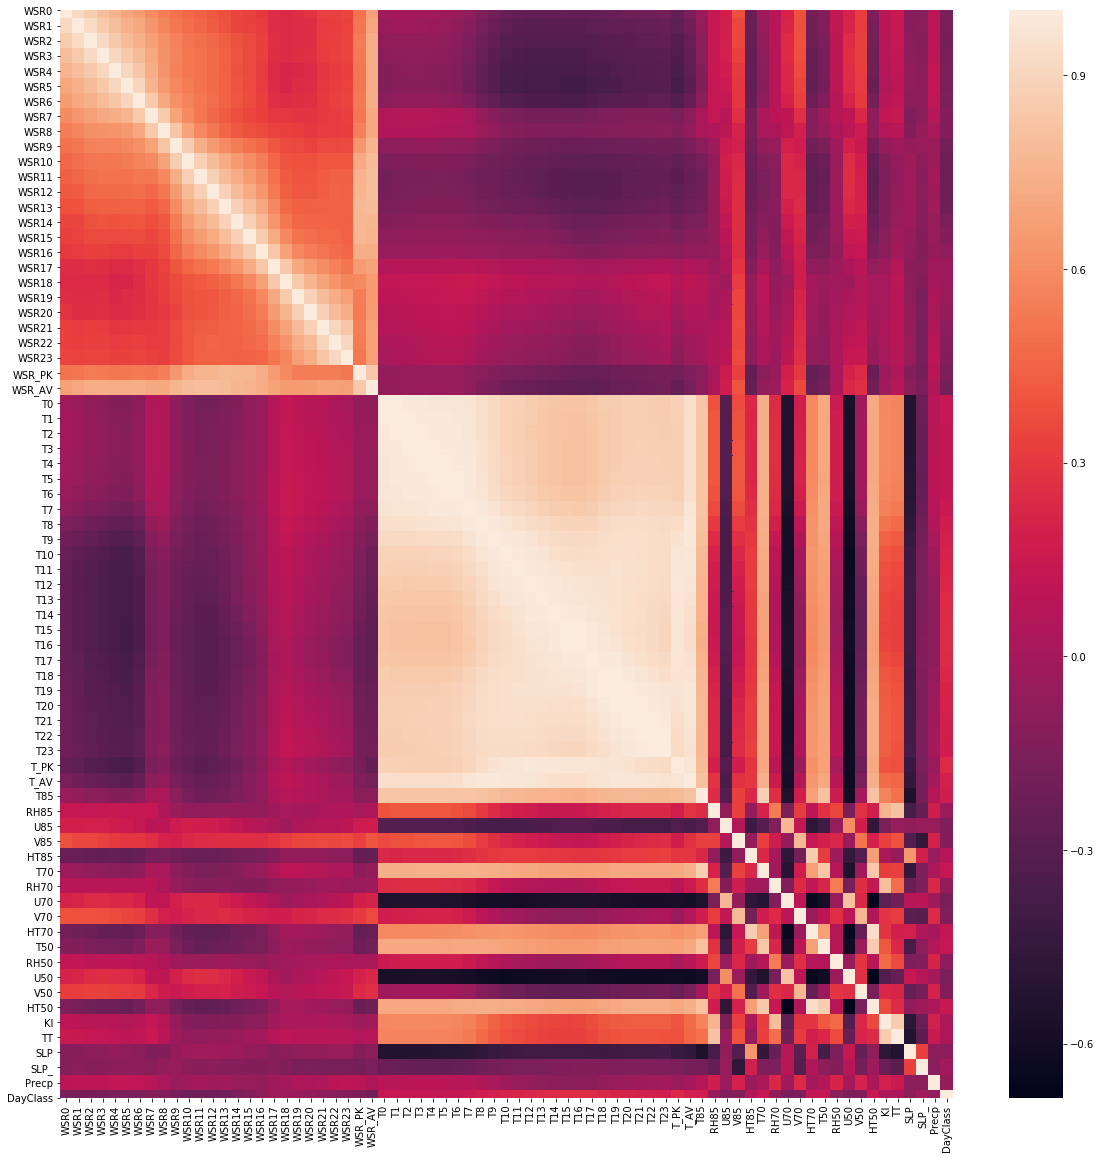

In [14]:
plt.figure(figsize=(20, 20))

sns.heatmap(df_converted.corr());

As shown in the heatmap, we can see clearly that the Temperatur features are strongly correlated with one another. We can also see that the wind speeds (WSR0-23) are also correlated.

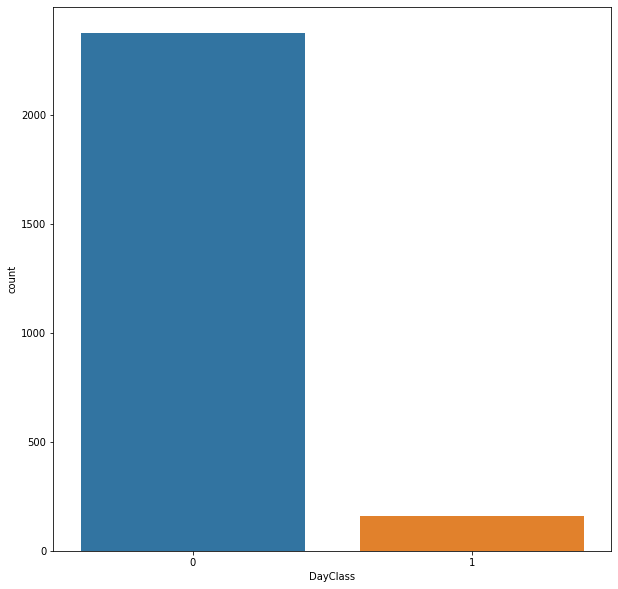

In [15]:
plt.figure(figsize=(10, 10))

sns.countplot(x="DayClass", data=df_converted)

As shown above, we can see that there are significantly more data of non-ozone days compared to ozone days. As such we need to ensure that we stratify our training and test sets.

# Scrubbing

In [0]:
target_attr = 'DayClass'
target_vals = {'ozone_day': 1, 'normal_day': 0}

In [17]:
X = df_converted.iloc[:, 1:-1]
y = df_converted[target_attr]
print('X:', X.shape)
print('y:', y.shape)
print(type(y))

X: (2534, 71)
y: (2534,)
<class 'pandas.core.series.Series'>


In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True,stratify=y)

In [0]:
minMaxScaler = MinMaxScaler()
X_train_scaled = minMaxScaler.fit_transform(X_train)
X_test_scaled = minMaxScaler.transform(X_train)

In [0]:
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.manifold import MDS
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA

lle = LocallyLinearEmbedding(n_components=2, random_state=42)
mds = MDS(n_components=2, random_state=42)
lda = LinearDiscriminantAnalysis(n_components=2)
pca = PCA(n_components=2, random_state=42)
pca_lle = Pipeline([
    ("pca", PCA(n_components=0.95, random_state=42)),
    ("lle", LocallyLinearEmbedding(n_components=2, random_state=42)),
])
reducer_results = {}

array([-0.01904131,  0.03622004, -0.01581818, ..., -0.02030085,
       -0.01737354, -0.01561209])

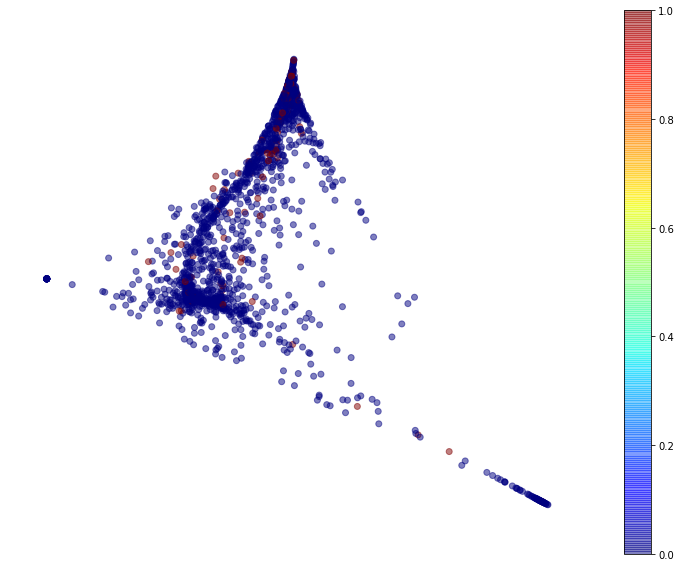

In [21]:
reducer_results["LLE"] = lle.fit_transform(X_train_scaled)
plt.figure(figsize=(13, 10))
plt.scatter(reducer_results["LLE"][:, 0], reducer_results["LLE"][:, 1], c=y_train, cmap="jet", alpha=0.5)
plt.axis('off')
plt.colorbar();
reducer_results["LLE"][:, 1]

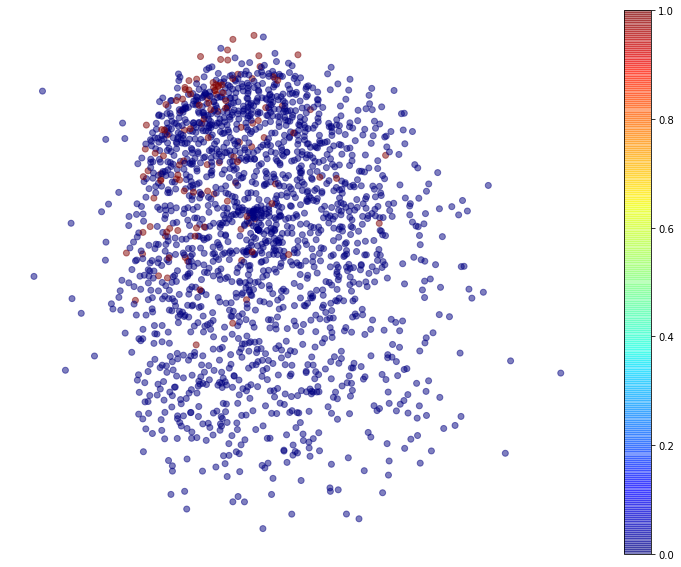

In [22]:
reducer_results["MDS"] = mds.fit_transform(X_train_scaled)
plt.figure(figsize=(13, 10))
plt.scatter(reducer_results["MDS"][:, 0], reducer_results["MDS"][:, 1], c=y_train, cmap="jet", alpha=0.5)
plt.axis('off')
plt.colorbar();

/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(71, 2 - 1) = 1 components.
  ChangedBehaviorWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)


(1900, 1)
(1900,)


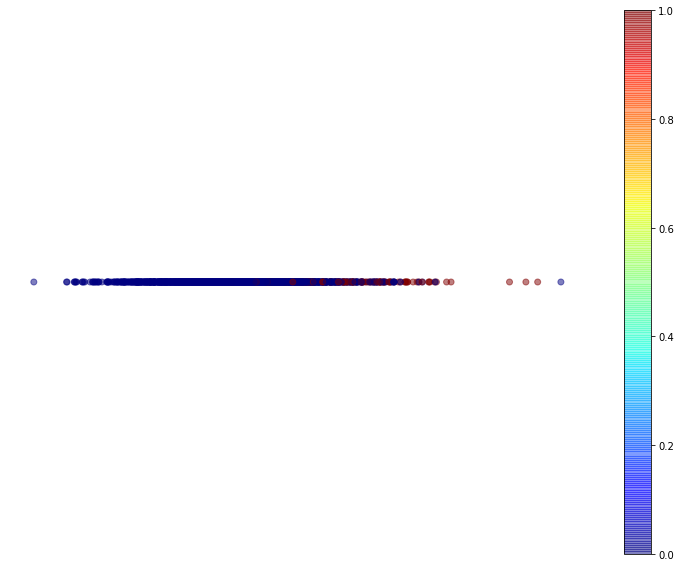

In [23]:
reducer_results["LDA"] = lda.fit_transform(X_train_scaled, y_train)
plt.figure(figsize=(13, 10))
plt.scatter(reducer_results["LDA"][:, 0], np.zeros(1900), c=y_train, cmap="jet", alpha=0.5)
plt.axis('off')
plt.colorbar();
print(reducer_results["LDA"].shape)
print(y_train.shape)

(1900, 2)


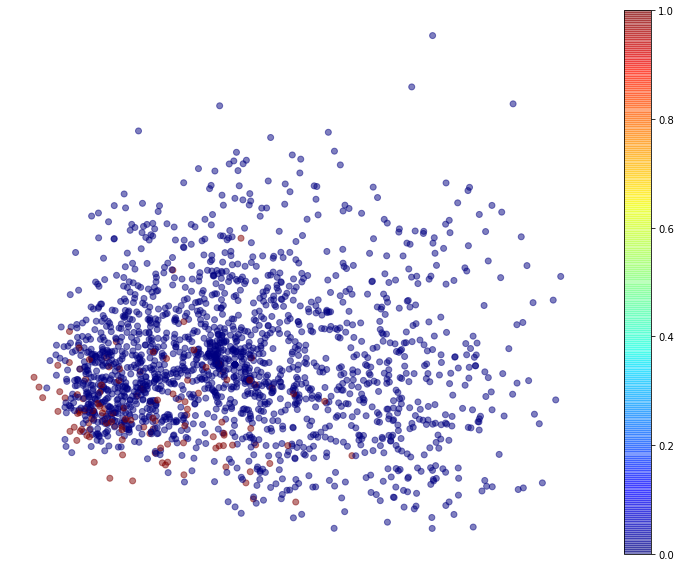

In [24]:
reducer_results["PCA"] = pca.fit_transform(X_train_scaled)
plt.figure(figsize=(13, 10))
plt.scatter(reducer_results["PCA"][:, 0], reducer_results["PCA"][:, 1], c=y_train, cmap="jet", alpha=0.5)
plt.axis('off')
plt.colorbar();
print(reducer_results["PCA"].shape)

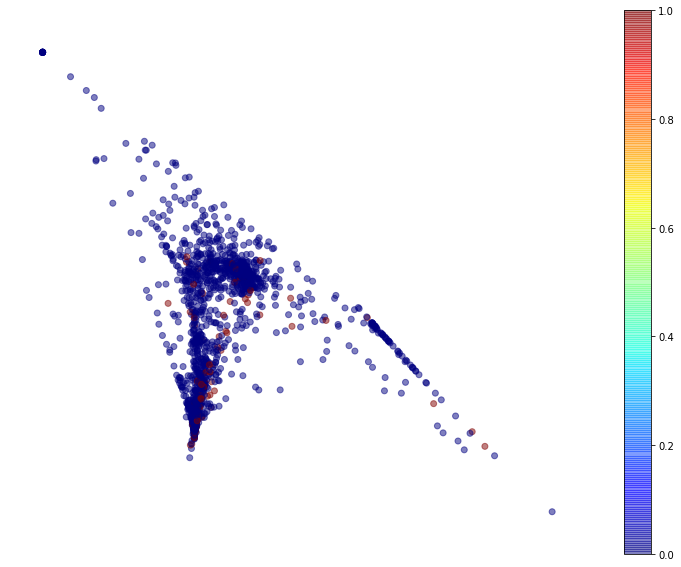

In [25]:
reducer_results["PCA_LLE"] = pca_lle.fit_transform(X_train_scaled)
plt.figure(figsize=(13, 10))
plt.scatter(reducer_results["PCA_LLE"][:, 0], reducer_results["PCA_LLE"][:, 1], c=y_train, cmap="jet", alpha=0.5)
plt.axis('off')
plt.colorbar();

Of the dimensionality reduction LDA seems to perform very well. It is interesting that the LDA also only outputted 1 component. This is because the target class we are dealing with is binary.

In [0]:
X_train_reduced = lda.transform(X_train_scaled)

In [0]:
skf = StratifiedKFold(n_splits=5, shuffle=True)
fold_indices = skf.split(X_train_reduced, y_train)

# Modeling

In [0]:
# Model imports
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier

In [29]:
#scaled_svm = Pipeline([
#        ("scaler", scaler),
#        ("linear_svc", svm),
#])
scv = SVC(gamma='auto') 
scv.fit(X_train_reduced, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [30]:
svm_scores = cross_validate(scv, X_train_reduced,y_train,scoring=["precision","recall", 'roc_auc', 'f1'],cv=10)
for key in svm_scores:
  print("%s %s" %(key, svm_scores[key].mean()))

fit_time 0.02884938716888428
score_time 0.008663153648376465
test_precision 0.7208333333333333
test_recall 0.20833333333333334
test_roc_auc 0.6994850187265917
test_f1 0.3169047619047619


In [0]:
def init_models():
    return [LogisticRegression(solver='lbfgs'),
            GaussianNB(),
            KNeighborsClassifier(n_neighbors=3),
            RandomForestClassifier(n_estimators=100),
            DecisionTreeClassifier(),
            SVC(gamma='scale'),
            SGDClassifier(random_state=42)]

def calc_metrics(model, X, y):
    y_hat = model.predict(X)
    metrics = [accuracy_score, precision_score, recall_score, f1_score, roc_auc_score]
    scores = [fn(y, y_hat) for fn in metrics]
    return scores

In [32]:
fold_model_sets = []
fold_model_metrics = []

for train_idx, val_idx in fold_indices:
    # Split training for cross val fold
    X_fold = X_train_reduced[train_idx]
    y_fold = y_train.iloc[train_idx]
    X_val = X_train_reduced[val_idx]
    y_val = y_train.iloc[val_idx]

    # Fit models
    models = init_models()
    fit_models = []
    fit_metrics = []
    for model in tqdm(models):
        fit_models.append(model.fit(X_fold, y_fold))
        fit_metrics.append(calc_metrics(model, X_val, y_val))
    
    # Store models and metrics for fold
    fold_model_sets.append(fit_models)
    fold_model_metrics.append(fit_metrics)

# Move to numpy
fold_model_metrics = np.array(fold_model_metrics)

 57%|█████▋    | 4/7 [00:00<00:00, 20.73it/s]/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
100%|██████████| 7/7 [00:00<00:00, 29.73it/s]


In [33]:
models = init_models()
model_names = []
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1', 'AUC']

mean_model_metrics = fold_model_metrics.mean(axis=0)
max_model_metrics = fold_model_metrics.max(axis=0)

for i in range(mean_model_metrics.shape[0]):
    print('\n')
    model_name = str(models[i]).split('(')[0]
    model_names.append(model_name)
    print(model_name)
    
    print('_' * len(model_name))
    
    for j in range(mean_model_metrics.shape[1]):
        print(f"{metric_names[j]}: {mean_model_metrics[i, j]:.3f} (max {max_model_metrics[i, j]:.3f})")



LogisticRegression
__________________
Accuracy: 0.947 (max 0.955)
Precision: 0.673 (max 0.818)
Recall: 0.325 (max 0.375)
F1: 0.434 (max 0.514)
AUC: 0.657 (max 0.685)


GaussianNB
__________
Accuracy: 0.945 (max 0.950)
Precision: 0.637 (max 0.727)
Recall: 0.333 (max 0.375)
F1: 0.434 (max 0.486)
AUC: 0.660 (max 0.682)


KNeighborsClassifier
____________________
Accuracy: 0.933 (max 0.945)
Precision: 0.458 (max 0.588)
Recall: 0.308 (max 0.417)
F1: 0.365 (max 0.488)
AUC: 0.642 (max 0.699)


RandomForestClassifier
______________________
Accuracy: 0.911 (max 0.926)
Precision: 0.298 (max 0.375)
Recall: 0.292 (max 0.417)
F1: 0.291 (max 0.375)
AUC: 0.622 (max 0.679)


DecisionTreeClassifier
______________________
Accuracy: 0.911 (max 0.926)
Precision: 0.298 (max 0.375)
Recall: 0.292 (max 0.417)
F1: 0.291 (max 0.375)
AUC: 0.622 (max 0.679)


SVC
___
Accuracy: 0.943 (max 0.953)
Precision: 0.692 (max 1.000)
Recall: 0.183 (max 0.250)
F1: 0.288 (max 0.400)
AUC: 0.589 (max 0.625)


SGDClassifier
__

In [34]:
metrics = pd.DataFrame(mean_model_metrics.T, columns=model_names, index=metric_names)
metrics

,LogisticRegression,GaussianNB,KNeighborsClassifier,RandomForestClassifier,DecisionTreeClassifier,SVC,SGDClassifier
Accuracy,0.946842,0.945263,0.932632,0.911053,0.911053,0.943158,0.932632
Precision,0.672552,0.637249,0.457659,0.297849,0.297849,0.691667,0.462890
Recall,0.325000,0.333333,0.308333,0.291667,0.291667,0.183333,0.308333
F1,0.434083,0.433761,0.364970,0.291061,0.291061,0.287738,0.313198
AUC,0.656882,0.659925,0.641526,0.622238,0.622238,0.588858,0.641526


In [35]:
from keras import backend as K

def recall_m(y_true, y_pred):
  true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
  recall = true_positives / (possible_positives + K.epsilon())
  return recall

def precision_m(y_true, y_pred):
  true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
  precision = true_positives / (predicted_positives + K.epsilon())
  return precision

def f1_m(y_true, y_pred):
  precision = precision_m(y_true, y_pred)
  recall = recall_m(y_true, y_pred)
  return 2*((precision*recall)/(precision+recall+K.epsilon()))

Using TensorFlow backend.


In [48]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras.layers import Dense, Dropout
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.optimizers import Nadam
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint
model = Sequential([
    Dense(36, activation='relu'),
    Dropout(0.2),
    Dense(18, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save = ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')

model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy',f1_m, precision_m,recall_m], callback=[earlyStopping,mcp_save])
y_train_N = np.asarray(y_train).reshape(-1,1)

(1900, 1)

In [49]:
history = model.fit(X_train_scaled,y_train_N,
                    epochs=150, batch_size=20, validation_split=0.3)

Train on 1330 samples, validate on 570 samples
Epoch 1/150
1330/1330 [==============================] - 1s 378us/sample - loss: 0.3101 - acc: 0.9271 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 0.2466 - val_acc: 0.9298 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/150
1330/1330 [==============================] - 0s 235us/sample - loss: 0.2305 - acc: 0.9398 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 0.2276 - val_acc: 0.9298 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 3/150
1330/1330 [==============================] - 0s 228us/sample - loss: 0.2058 - acc: 0.9398 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 0.2103 - val_acc: 0.9298 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 4/150
1330/1330 [==============================] - 0s 230us/sample - loss: 0.1975 - ac

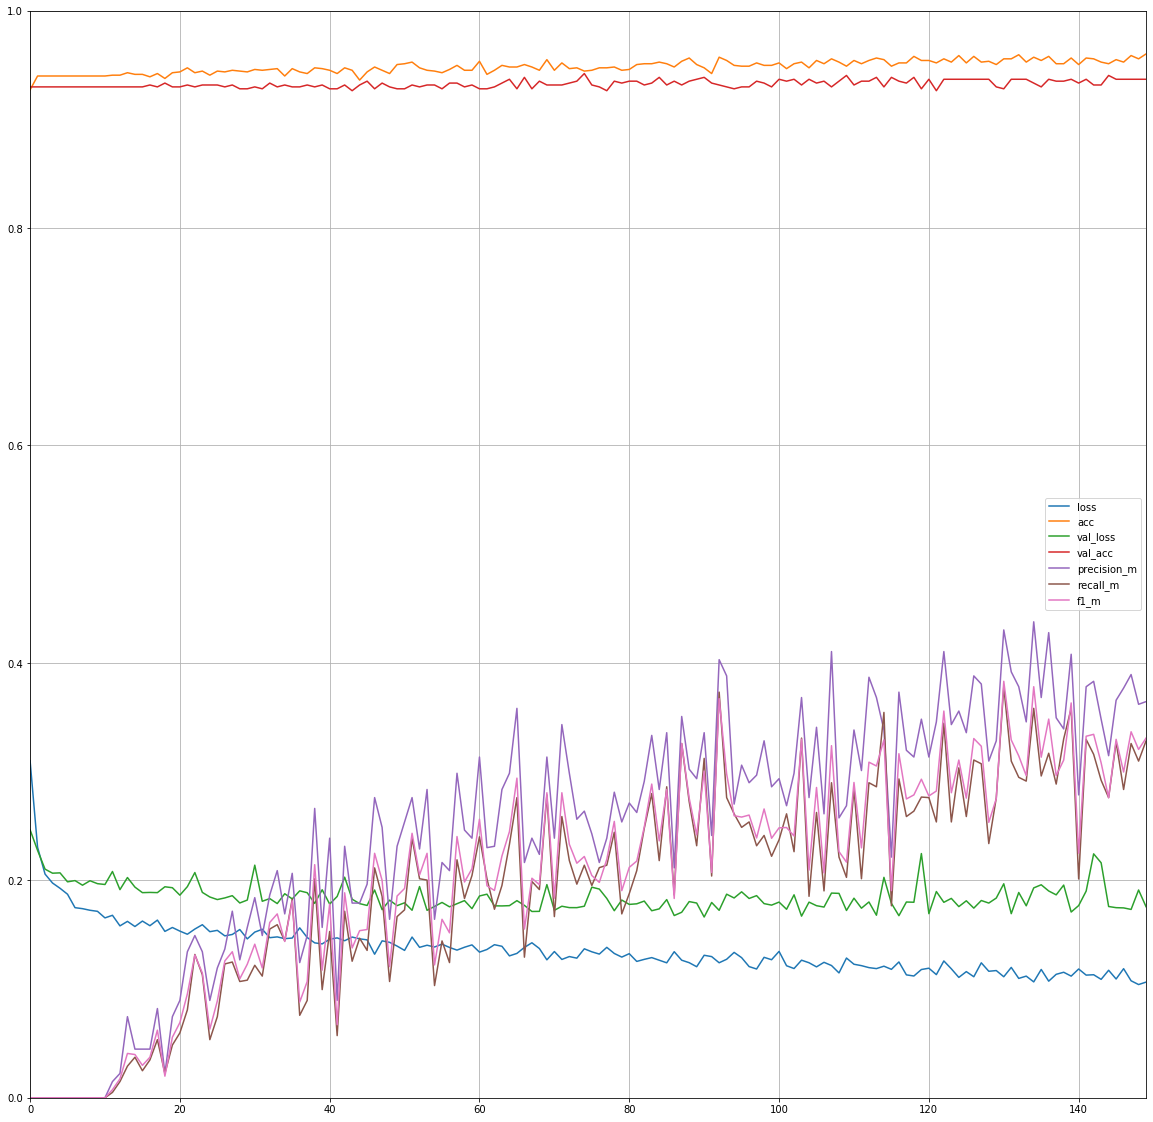

In [50]:
subset = {x: history.history[x] for x in ['loss','acc','val_loss','val_acc','precision_m','recall_m','f1_m'] if x in history.history}
pd.DataFrame(subset).plot(figsize=(20, 20))
plt.grid(True)
plt.gca().set_ylim(0, 1);

In [64]:
score = model.evaluate(X_train_scaled, y_train)
score[0]

1900/1900 [==============================] - 0s 73us/sample - loss: 0.1284 - acc: 0.9521 - f1_m: 0.5103 - precision_m: 0.5514 - recall_m: 0.5294


0.12838168793602994

In [0]:
metrics.insert(7,"Neural Network",[score[1],score[3],score[4],score[2], 0])

In [82]:
metrics

,LogisticRegression,GaussianNB,KNeighborsClassifier,RandomForestClassifier,DecisionTreeClassifier,SVC,SGDClassifier,Neural Network
Accuracy,0.946842,0.945263,0.932632,0.911053,0.911053,0.943158,0.932632,0.952105
Precision,0.672552,0.637249,0.457659,0.297849,0.297849,0.691667,0.462890,0.551389
Recall,0.325000,0.333333,0.308333,0.291667,0.291667,0.183333,0.308333,0.529405
F1,0.434083,0.433761,0.364970,0.291061,0.291061,0.287738,0.313198,0.510265
AUC,0.656882,0.659925,0.641526,0.622238,0.622238,0.588858,0.641526,0.000000
